# Feature Engineering

In [7]:
import os
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from audio_processing import AudioProcessor

In [8]:
INPUT_FILE = '../data/cleaned/70_15_15_cleaned_train.parquet'
INPUT_AUDIO_DIR = '../data/raw/audio/xeno_canto'
OUTPUT_SPECTROGRAM_DIR = '../data/processed/spectrograms/xeno_canto'
OUTPUT_FEATURE_DIR = '../data/processed/features/xeno_canto'
TARGET_RECORDINGS = 100


os.makedirs(OUTPUT_SPECTROGRAM_DIR, exist_ok=True)
os.makedirs(OUTPUT_FEATURE_DIR, exist_ok=True)

df = pd.read_parquet(INPUT_FILE)
species_counts = df['en'].value_counts()

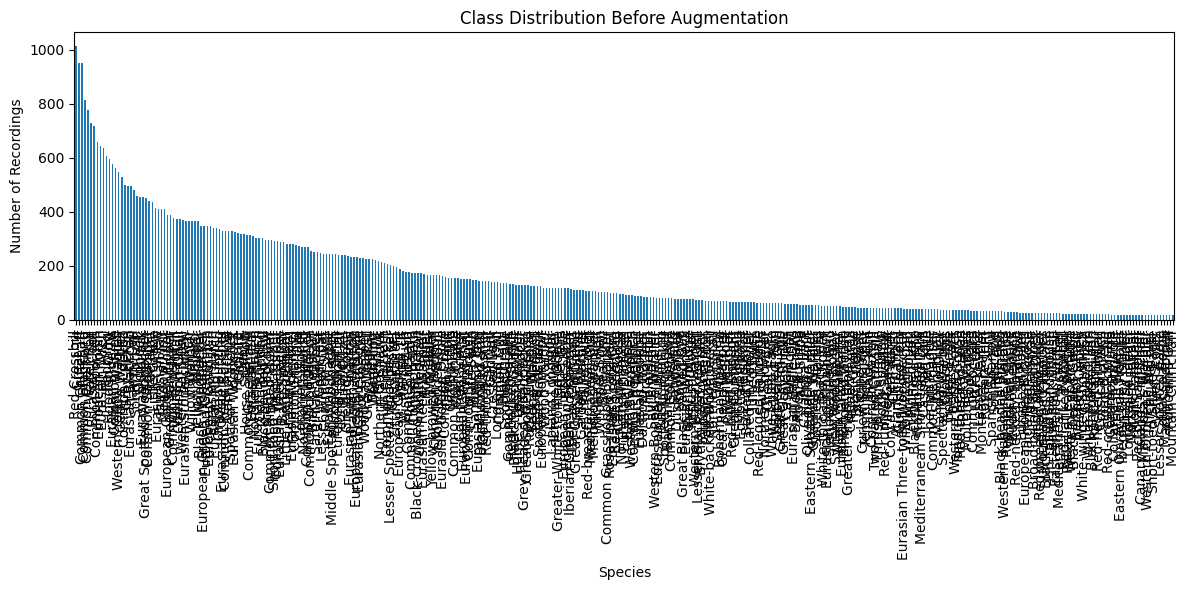

In [9]:
plt.figure(figsize=(12, 6))
species_counts.plot(kind='bar')
plt.title('Class Distribution Before Augmentation')
plt.xlabel('Species')
plt.ylabel('Number of Recordings')
plt.tight_layout()
plt.show()

In [ ]:
augmentation_factors = {}
for species, count in species_counts.items():
    if count > 100:
        max_augment_per_sample = 1
    elif count > 50:
        max_augment_per_sample = 2
    elif count > 25:
        max_augment_per_sample = 5
    else:
        max_augment_per_sample = 10

    needed_augmentations = max(0, TARGET_RECORDINGS - count)
    augmentation_factors[species] = min(
        max(1, needed_augmentations // count), max_augment_per_sample
    )

# Process each row in the dataset
species_counts_after_aug = {species: 0 for species in species_counts.index}

ap = AudioProcessor(sample_rate=22050, segment_duration=20, target_db_level=-20, seed=42)

for _, row in tqdm(df.iterrows(), total=len(df)):
    audio_id = row['id']
    species_name = row['en']
    audio_files = glob.glob(os.path.join(INPUT_AUDIO_DIR, f"{audio_id}.*"))

    if len(audio_files) != 1:
        print(f"Skipping ID {audio_id}: {'No' if not audio_files else 'Multiple'} audio files found.")
        continue

    audio_path = audio_files[0]
    try:
        # Process original audio
        y = ap.process_audio_file_with_denoising(audio_path)
        S_db = ap.create_log_mel_spectrogram(y, n_fft=2048, hop_length=512, n_mels=128)  # Updated to include parameters
        ap.save_log_mel_spectrogram(S_db, os.path.join(OUTPUT_SPECTROGRAM_DIR, f"{audio_id}_logmel.npy"))

        combined_features = ap.create_combined_features(y)
        ap.save_combined_features(combined_features, os.path.join(OUTPUT_FEATURE_DIR, f"{audio_id}_combined.npy"))
        species_counts_after_aug[species_name] += 1

        # Apply augmentations
        for i in range(augmentation_factors.get(species_name, 0)):
            y_aug = ap.add_augmentations(y)
            S_db_aug = ap.apply_spectrogram_augmentation(
                ap.create_log_mel_spectrogram(y_aug, n_fft=2048, hop_length=512, n_mels=128),
                time_mask_lower=50, time_mask_upper=100,
                freq_mask_lower=1, freq_mask_upper=7
            )
            ap.save_log_mel_spectrogram(S_db_aug, os.path.join(OUTPUT_SPECTROGRAM_DIR, f"{audio_id}_aug_{i}_logmel.npy"))

            combined_features_aug = ap.create_combined_features(y_aug)
            ap.save_combined_features(combined_features_aug, os.path.join(OUTPUT_FEATURE_DIR, f"{audio_id}_aug_{i}_combined.npy"))
            species_counts_after_aug[species_name] += 1

    except Exception as e:
        print(f"Error processing ID {audio_id}: {e}")

print("Processing complete.")


  0%|          | 20/57880 [00:22<17:57:27,  1.12s/it]

Processing complete.


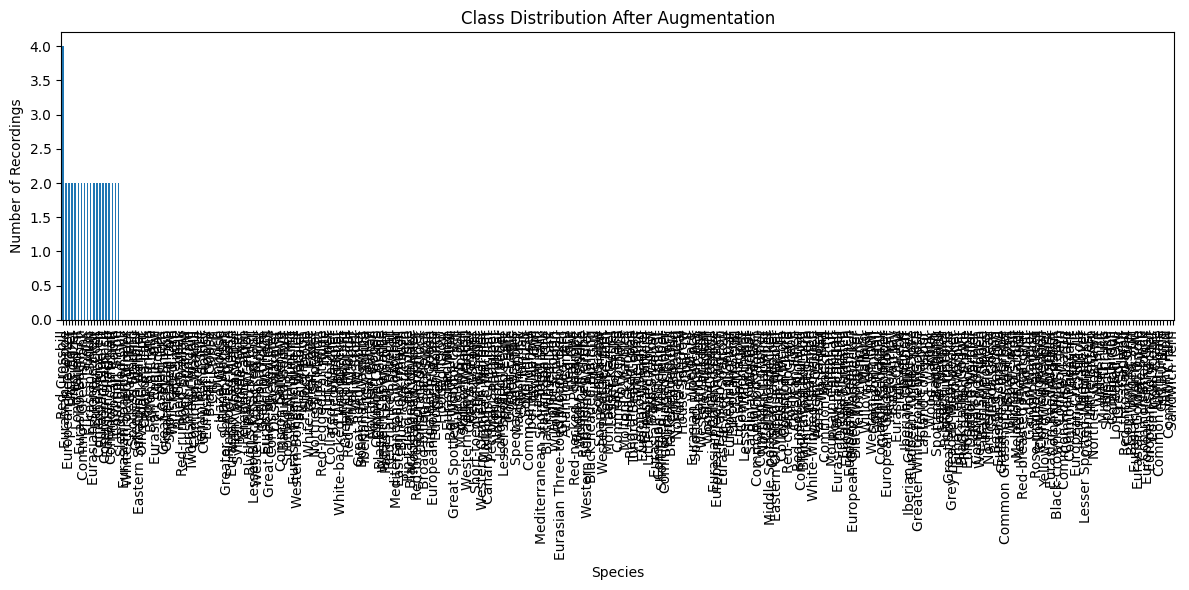

In [11]:
species_counts_after_aug_series = pd.Series(species_counts_after_aug)
species_counts_after_aug_series = species_counts_after_aug_series.sort_values(ascending=False)
plt.figure(figsize=(12, 6))
species_counts_after_aug_series.plot(kind='bar')
plt.title('Class Distribution After Augmentation')
plt.xlabel('Species')
plt.ylabel('Number of Recordings')
plt.tight_layout()
plt.show()